# Unsupervised Learning Project: Creating Customer Segments


In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. 

The dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. The code block below produces a statistical summary for each of the above product categories.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Selecting Samples

To get a better understanding of the customers and how their data will transform through the analysis, lets select a few sample data points and explore them in more detail.

In [3]:
indices = [26,176,392]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9898,961,2861,3151,242,833
1,45640,6958,6536,7368,1532,230
2,518,4180,3600,659,122,654


### Guessing Establishments

Considering the total purchase cost of each product category and the statistical description of the dataset above for our sample customers. What kind of establishment (customer) could each of the three samples we've chosen represent?  

Looking at the total purchase of each product category above and comparing them with the medians of the distributions, we can guess that: 

- The first customer in the sample (Index 0), might be from a restaurant. We see high amounts of Frozen, close to median amount of Fresh and Deli. So this can be from a restaurant.
- The second customer in the sample (Index 1), might be from a supermarket. We see really high or close to median levels of purchases of all category of products excluding deli. So maybe the supermarket doesn't have a deli section.
- The third customer in the sample (Index 2), might represent a cafe. We see a high purchase of milk and somewhat close to median levels for Groceries and Deli. We also see a relatively lower purchase of fresh produce and frozen goods. 

### Feature Relevance

One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature. 

Lets do this for the 'Milk' feature.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

new_data = data.drop(['Milk'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(new_data,data['Milk'],test_size=0.25,random_state=101)

regressor = DecisionTreeRegressor(random_state=101).fit(X_train,y_train)

score = regressor.score(X_test,y_test)

print(score)

0.29571438444092835


#### Feature Relevance Prediction

We tried to predict the 'Milk' feature (i.e. annual spending on milk products), based on the other features in the dataset (annual spending on other product categories). 

The predicted R<sup>2</sup> score was 0.2957. As we know that the R<sup>2</sup> is between 0 and 1, the model we built for customer's milk purchasing habits isn't very good, although it is possible that there's some correlation between this feature and others.  

It's safe to say that the 'Milk' feature is necessary for identifying customer's spending habits because it isn't possible to predict how a customer spends on Milk based on their spending on the other product categories. We can say that the 'Milk' feature adds extra (and maybe key) information to the data which is not easily inferable by model only through looking at the other features. 

### Visualize Feature Distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If it is found that the feature we attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if we believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

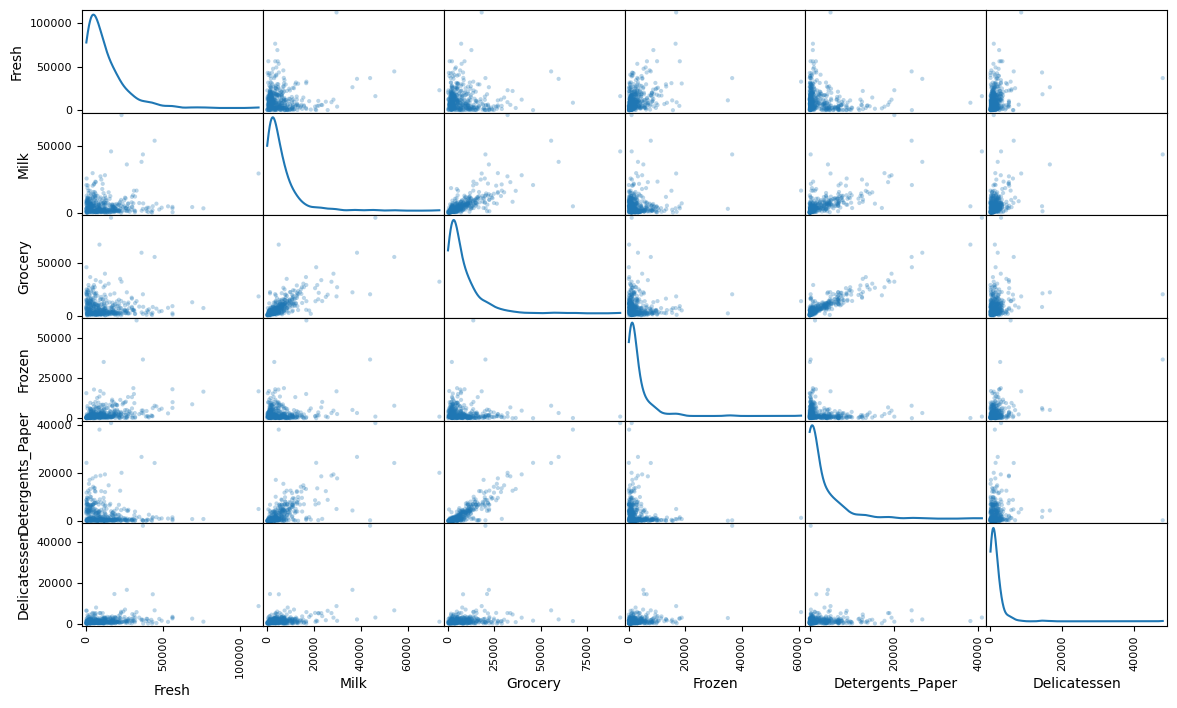

In [5]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

#### Correlations

Looking at the plot above, there are a few pairs of features that exhibit some degree of correlation. They include: 

- Milk and Groceries
- Milk and Detergents_Paper
- Grocery and Detergents_Paper

As we tried to predict the 'Milk' feature earlier, this confirms the suspicion that Milk isn't correlated to most of the features in the dataset, although it shows a mild correlation with 'Groceries' and 'Detergents_Paper'.

The distribution of all the features appears to be similar. It is strongly right skewed, in that most of the data points fall in then first few intervals. Judging by the summary statistics, especially the mean and maximum value points, of the features that we calculated earlier, we can expect that there are some outliers in each of the distributions. This conforms with the fact that there's a significant different between the mean and the median of the feature distributions.

## Data Preprocessing

In this section, we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Feature Scaling

If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

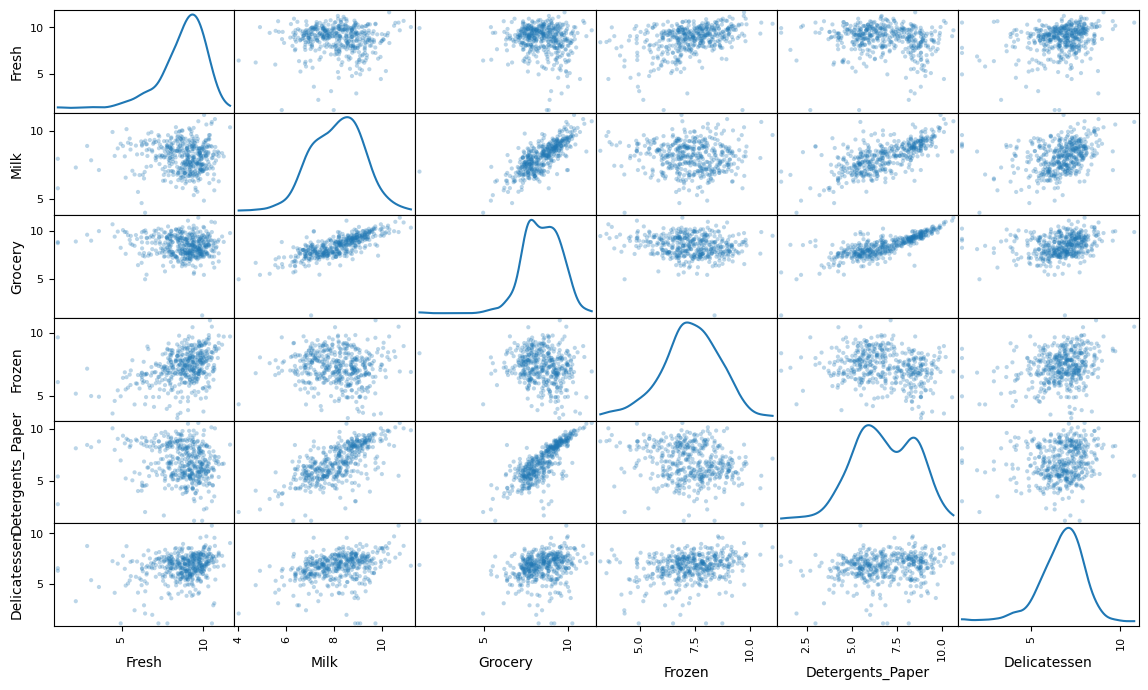

In [6]:
# Scale the data using the natural logarithm
log_data = data.apply(lambda x: np.log(x))

# Scale the sample data using the natural logarithm
log_samples = samples.apply(lambda x: np.log(x))

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. 

Let's check out our log transformed samples.

In [7]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.200088,6.867974,7.958926,8.055475,5.488938,6.725034
1,10.728540,8.847647,8.785081,8.904902,7.334329,5.438079
2,6.249975,8.338067,8.188689,6.490724,4.804021,6.483107


### Outlier Detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [8]:
# Select the indices for data points you wish to remove
outliers  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    out = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(out)
    outliers = outliers + list(out.index.values)
    

#Creating list of more outliers which are the same for multiple features.
outliers = list(set([x for x in outliers if outliers.count(x) > 1]))    

print("Outliers: {}".format(outliers))

# Remove the outliers, if any were specified 
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
print("The good dataset now has {} observations after removing outliers.".format(len(good_data)))

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Outliers: [128, 65, 66, 75, 154]
The good dataset now has 435 observations after removing outliers.


Upon quick inspection, our sample doesn't contain any of the outlier values.

There were 5 data points that were considered outliers for more than one feature based on our definition above. So, instead of removing all outliers (which would result in us losing a lot of information), only outliers that occur for more than one feature are removed.

We can also analyse these outliers independently to answer questions about how or when they occur (root cause analysis), but they might not be suitable for an aggregate analysis.  

## Feature Transformation

In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

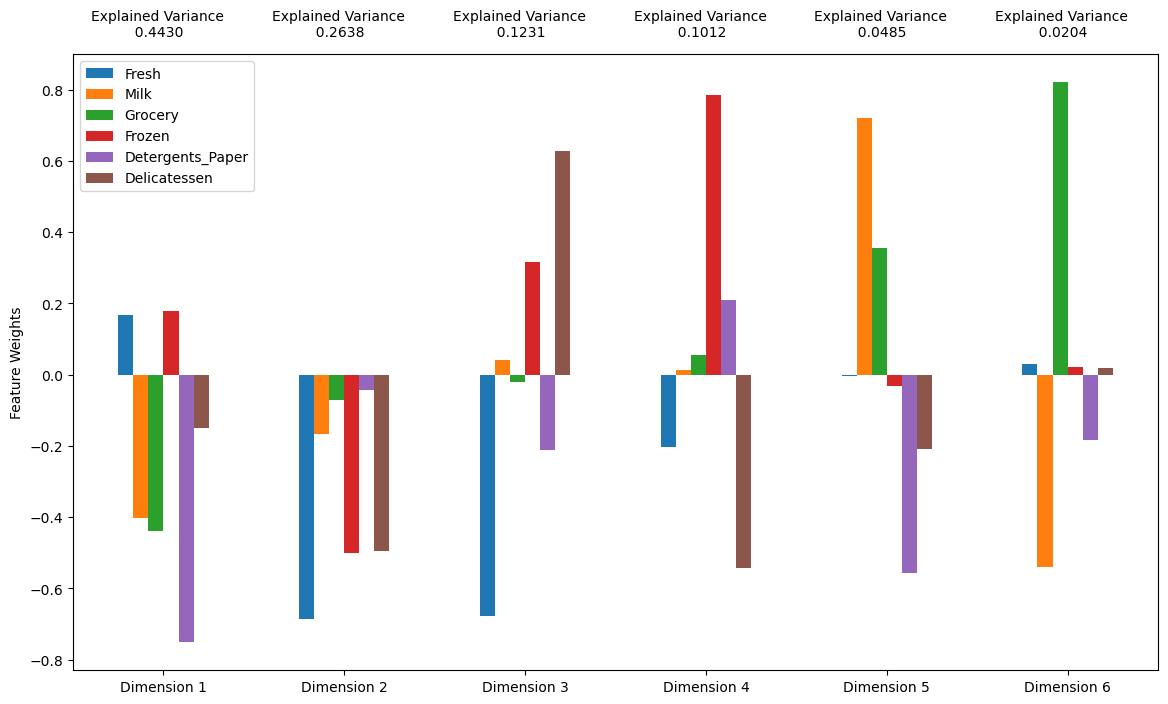

In [9]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA().fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

The first and second features, in total, explain approx. 70.8% of the variance in our data.

The first four features, in total, explain approx. 93.11% of the variance. 

In terms of customer spending, 
- **Dimension 1** has a high positive weight for Milk, Grocery, and Detergents_Paper features. This might represent Hotels, where these items are usually needed for the guests.
- **Dimension 2** has a high positive weight for Fresh, Frozen, and Delicatessen. This dimension might represent 'restaurants', where these items are used for ingredients in cooking dishes. 
- **Dimension 3** has a high positive weight for Deli and Frozen features, and a low posiive weight for Milk, but has negative weights for everything else. This dimension might represent Delis. 
- **Dimension 4** has positive weights for Frozen,Detergents_Paper and Groceries, while being negative for Fresh and Deli. It's a bit tricky to pin this segment down, but I do believe that there are shops that sell frozen goods exclusively. 

Let's see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions.

In [10]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.9083,-0.3765,0.1924,0.1502,-0.3852,0.5367
1,-0.0349,-1.6819,-1.7115,1.6613,0.5394,-0.1548
2,0.9955,2.3169,1.7454,-0.4569,1.2462,-0.0669


### Dimensionality Reduction

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In [11]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

Let's see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions.

In [12]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.9083,-0.3765
1,-0.0349,-1.6819
2,0.9955,2.3169


### Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

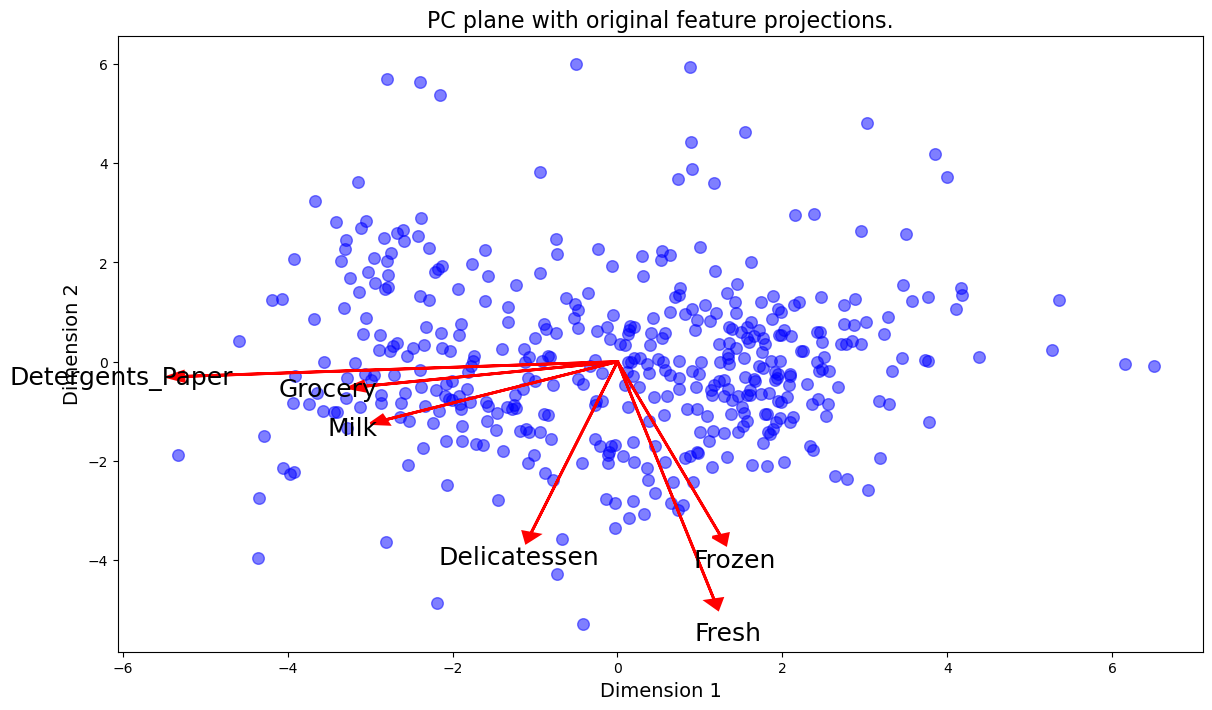

In [13]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

## Clustering

In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### K-Means or Gaussian Mixture Model?

From what we know of both models.

Advantages of K-Means clustering: 

- Simple, easy to implement and interpret results.
- Good for hard cluster assignments i.e. when a data point only belongs to one cluster over the others.

Advantages of Gaussian Mixture Model clustering: 

- Good for estimating soft clusters i.e. we're not sure if a point belongs to one cluster over another.
- Does not bias the cluster sizes to have specific structures in the cluster that may or may not exist.

Gven what we know about the wholesale customer data so far, we'll chose to use Gaussian Mixture Model clustering over K-Means. This is because there might be some hidden patterns in the data that we may miss by assigning only one cluster to each data point. For example, let's take the case of the Supermarket customer in our sample: while doing PCA, it had similar and high positive weights for multiple dimensions, i.e. it didn't belong to one dimension over the other. So a supermarket may be a combination of a fresh produce store/grocery store/frozen goods store.

We'll choose GMM, so that we don't miss cases like these. 

### Creating Clusters

Depending on the problem, the number of clusters that we expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [14]:
n_clusters = [8,6,4,3,2]

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for n in n_clusters:
    
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    
    print("The silhouette_score for {} clusters is {}".format(n,score))

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


The silhouette_score for 8 clusters is 0.31806514882854475
The silhouette_score for 6 clusters is 0.3295749195529708
The silhouette_score for 4 clusters is 0.3197939603658813
The silhouette_score for 3 clusters is 0.3660831658057789
The silhouette_score for 2 clusters is 0.42232468264593864


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


Of the several cluster numbers tried, 2 clusters had the best silhouette score.

### Cluster Visualization

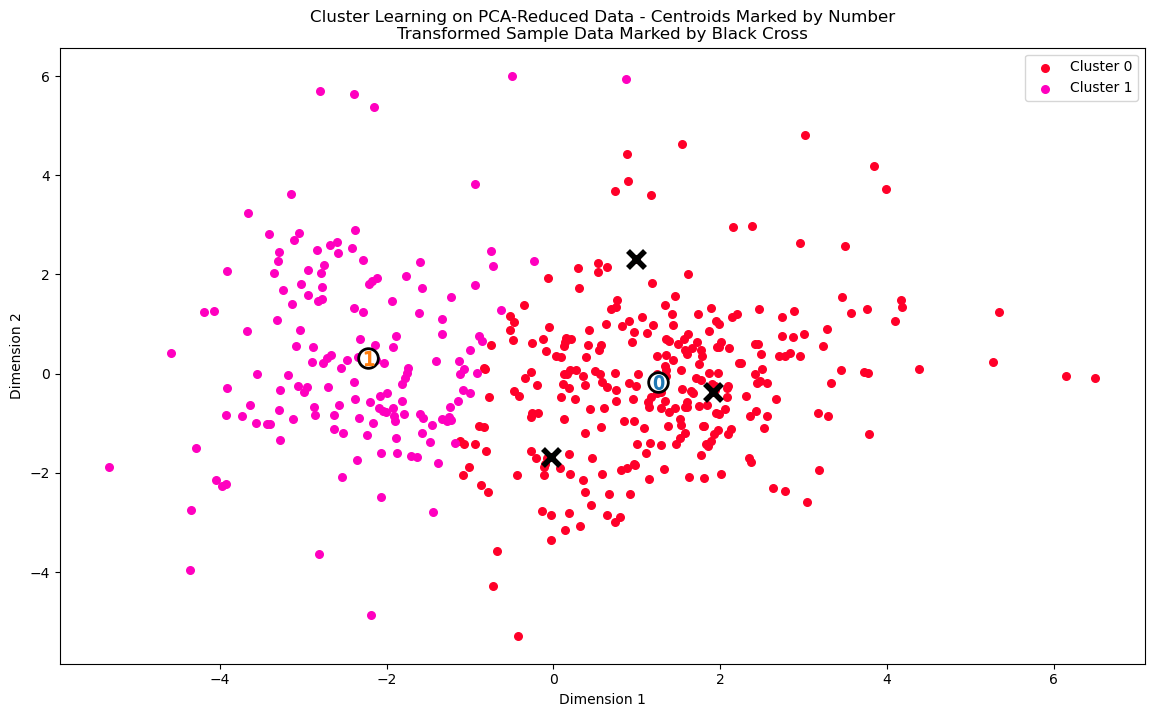

In [15]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Data Recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [16]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8939.0,2108.0,2758.0,2073.0,352.0,730.0
Segment 1,3567.0,7860.0,12249.0,873.0,4713.0,966.0


An interesting observation here could be, considering the total purchase cost of each product category for the representative data points above, and referencing the statistical description of the dataset at the beginning of this project, what set of establishments could each of the customer segments represent?

Taking an educated guess,

- **Segment 0**: This segment best represents supermarkets. They spend a higher than median amount on Milk, Grocery, Detergents_Paper and Deli, which are both essential to be stocked in such places.

- **Segment 1**: This segment best represents restaurants. Their spend on Fresh, and Frozen is higher than the median, and lower, but still close to median on Deli. Their spend on Milk, Grocery and Detergents_Paper is lower than median, which adds to our assessment. 

Let's find which cluster each sample point is predicted to be.

In [17]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


Our guesses for Sample points 0,1, and 2 were restaurants, supermarket and cafe. It seems like we're close on the predictions for sample points 0 and 2, while incorrect, or rather inconsistent, with our predictions for sample point 1. Looking at the visualization for our cluster in the previous section, it could be that sample 1 is the point close to the boundary of both clusters.

## Conclusion and Implications: How to use this knowledge?

In this final section, we will investigate ways that you can make use of the clustered data. First, we will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Then, we will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data.

Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

#### How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?

Making the change to the delivery service means that products will be delivered fewer times in a week. 

The wholesale distributor can identify the clusters to conduct the A/B test on, but the test should be done on one cluster at a time because the two clusters represent different types of customers, so their delivery needs might be different, and their reaction to change will, thus, be different. In other words, the control and experiment groups should be from the same cluster, at a time.

Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  

#### How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?

To label the new customers, the distributor will first need to build and train a supervised learner on the data that we labeled through clustering. The data to fit will be the estimated spends, and the target variable will be the customer segment i.e. 0 or 1 (i.e. grocery store or restaurant). They can then use the classifier to predict segments for new incoming data.